In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

from utils import count_letters, print_line, read_inputs, score

In [3]:
class Tokeniser:
    """
    A class for encoding and decoding strings into tokens for model input.

    Attributes
    ----------
    length : int
        Expected length of input strings. Defaults to 20.
    char_to_id : dict
        Dictionary mapping characters to their corresponding token IDs.
    id_to_char : dict
        Dictionary mapping token IDs to their corresponding characters.

    Methods
    -------
    encode(string: str) -> torch.Tensor
        Encodes a string into a tensor of token IDs.
    
    decode(tokens: torch.Tensor) -> str
        Decodes a tensor of token IDs into a string.
    """
    def __init__(self, length: int = 20):
        """
        Initialises the tokeniser, defining the vocabulary.

        Parameters
        ----------
        length : int, optional
            Expected length of input strings. Defaults to 20.
        """
        self.length = length
        
        vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' '] # vocab of lowerchase chars and space

        self.char_to_id = {ch: i for i, ch in enumerate(vocab)} # dictionary of character to token id
        self.id_to_char = {i: ch for i, ch in enumerate(vocab)} # dictionary of token id to character
    
    def encode(self, string: str) -> torch.Tensor:
        """
        Encodes a string into a tensor of token IDs.

        Parameters
        ----------
        string : str
            The input string to encode.
        
        Returns
        -------
        torch.Tensor (shape [self.length])
            A tensor containing the token IDs corresponding to input string.
            
        Raises
        ------
        ValueError
            If 'string' is not 'self.length' characters long.
            If 'string' contains out-of-vocabulary characters.
        """
        if len(string) != self.length: # ensure input string is correct length
            raise ValueError(f"Input string must be exactly {self.length} characters long, but got {len(string)} characters.")
        
        try:
            tokens_list = [self.char_to_id[c] for c in string] # convert string to tokens list
        except KeyError as e:
            raise ValueError(f"Out of vocabulary character encountered: '{e.args[0]}'")
        
        tokens_tensor = torch.tensor(tokens_list, dtype=torch.long) # convert token list into tensor
        return tokens_tensor
    
    def decode(self, tokens: torch.Tensor) -> str:
        """
        Decodes a tensor of token IDs into a string.

        Parameters
        ----------
        tokens : torch.Tensor
            A tensor containing token IDs to decode.
        
        Returns
        -------
        str
            A decoded string corresponding to input tokens.
        """
        return "".join([self.id_to_char[i.item()] for i in tokens])

In [4]:
def batch_tensor(tensor_list, batch_size) -> torch.Tensor:
    """
    Converts a list of 1D tensors into a batched 3D tensor. Used with 'process_dataset'.

    Parameters
    ----------
    tensor_list : list of torch.Tensor
        A list of 1D tensors to be batched together.
    batch_size : int
        The number of tensors to include in each batch.
    
    Returns
    -------
    torch.Tensor (shape [num_batches, batch_size, tensor_length])
        A 3D batched tensor, grouping each input tensor into groups of size 'batch_size'.
    """
    tensor_stacked = torch.stack(tensor_list) # convert list of 1D tensors to stacked 2D tensor
    
    num_batches = len(tensor_stacked) // batch_size # find whole number of batches (may trim last items)
    excess_items = len(tensor_stacked) % batch_size # calculate number of extra items which don't fit into batches
    if excess_items != 0:
        print(f"Trimming last {excess_items} items to ensure equal batch sizes.")
        tensor_stacked = tensor_stacked[:-excess_items] # trim tensor
    
    batched_tensor = tensor_stacked.view(num_batches, batch_size, -1) # reshape 2D tensor into batched 3D tensor
    return batched_tensor
    

def process_dataset(inputs, tokeniser, batch_size = 4) -> dict:
    """
    Processes raw data into input tokens and labels, creating a dataset dictionary of batched tensors.

    Parameters
    ----------
    inputs : list of str
        Train or test data examples split into a list.
    tokeniser : Tokeniser
        An instance of the Tokeniser class used to encode the input.
    batch_size : int, optional
        The number of items to include in each batch. Defaults to 4.

    Returns
    -------
    dict
        - 'input_ids' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of tokenised input strings.
        - 'labels' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of labels corresponding to input IDs.
    
    Raises
    ------
    ValueError
        If length of 'inputs' is less than 'batch_size'.
    """
    
    if len(inputs) < batch_size:
        raise ValueError("Input list is too short for a single batch.")

    random.shuffle(inputs) # shuffle incase inputs are ordered
    input_ids_list = [tokeniser.encode(text) for text in inputs] # list of token tensors for each input
    labels_list = [count_letters(text) for text in inputs] # list of label tensors for each input

    # create dictionary of batched 3D input and label tensors
    dataset = {
        'input_ids': batch_tensor(input_ids_list, batch_size),
        'labels': batch_tensor(labels_list, batch_size)
    }
    print("Dataset created.", ", ".join([f"{key}: {tensor.size()}" for key, tensor in dataset.items()]))
    print_line()
    return dataset

In [124]:
class BERTEmbedding(nn.Module):
    """
    A class for a BERT Embedding layer which creates and combines token and position embeddings.

    Attributes
    ----------
    length : int
        Expected length of input strings. Defaults to 20.
    token_embedding : nn.Embedding
        Embedding layer which maps each token to a dense vector of size 'embed_dim'.
    position_embedding : nn.Embedding
        Embedding layer which maps each position index to a dense vector of size 'embed_dim'.
    dropout : nn.Dropout
        Dropout layer for regularisation.

    Methods
    -------
    forward(input_ids: torch.Tensor) -> torch.Tensor
        Performs a forward pass, computing the BERT embeddings used as model input for a given 'input_ids'.
    """
    def __init__(
        self,
        embed_dim: int,
        dropout: float,
        vocab_size: int,
        length: int,
    ):
        """
        Initialises the BERT Embedding.

        Parameters
        ----------
        vocab_size : int
            Total number of unique tokens.
        length : int
            Expected length of input strings.
        embed_dim : int
            Dimensionality of the token and position embeddings.
        dropout : float
            Dropout probability, used for regularisation.
        """
        super().__init__() # initialise the nn.Module parent class
        self.length = length # store the sequence length

        self.token_embedding = nn.Embedding(vocab_size, embed_dim) # map each token to a dense vector of size embed_dim
        self.position_embedding = nn.Embedding(length, embed_dim) # map each position index to a dense vector of size embed_dim
        self.dropout = nn.Dropout(dropout) # dropout layer for regularisation


    def forward(
        self,
        input_ids: torch.Tensor
    ) -> torch.Tensor:
        """
        Performs a forward pass, computing the BERT embeddings used as model input for a given 'input_ids'.

        Parameters
        ----------
        input_ids : torch.Tensor (shape [batch_size, length])
            The tensor containing token indices for the input sequences of a given batch.

        Returns
        -------
        torch.Tensor  (shape [batch_size, length, embed_dim])
            The tensor containing the BERT embeddings for the input sequences of a given batch.
        """
        device = input_ids.device # used to ensure all tensors are on same device

        token_embedding = self.token_embedding(input_ids) # look up token embeddings for each token in input_ids

        position_input = torch.arange(self.length, device=device).unsqueeze(0) # create position indices for each token
        position_embedding = self.position_embedding(position_input) # look up position embeddings for each position index in input_ids
        
        embedding = token_embedding + position_embedding # BERT embedding is element-wise sum of token embeddings and position embeddings
        embedding = self.dropout(embedding) # apply dropout for regularisation
        return embedding

In [145]:
class TransformerLayer(nn.Module):
    """
    A class for a single Transformer layer composed of multi-head attention, normalisation, and feed-forward layers.
    
    Attributes
    ----------
    attention : nn.MultiheadAttention
        Attention mechanism capturing the relationships between each item in the input sequence.
    layer_norm1 : nn.LayerNorm
        Normalisation of the attention sub-layer, for stability.
    feedforward : nn.Sequential
        Two layer deep feed-forward network to process the attention sub-layer.
    layer_norm2 : nn.LayerNorm
        Normalisation of the feed-forward sub-layer, for stability.
    dropout : nn.Dropout
        Dropout layer for regularisation.

    Methods
    -------
    forward(input_ids: torch.Tensor) -> torch.Tensor
        Performs a forward pass, computing the intermediate transformer output representation.
    """
    def __init__(self, embed_dim: int, attention_heads: int, dropout: float):
        """
        Initialises the BERT Model.

        Parameters
        ----------
        embed_dim : int
            Dimensionality of the embeddings.
        dropout : float
            Dropout probability, used for regularisation.
        attention_heads : int
            The number of attention heads in the Transformer encoder layer.
        """
        super().__init__()

        self.attention = nn.MultiheadAttention(embed_dim, attention_heads, dropout=dropout, batch_first=True) # attention mechanism capturing relationships between each item in input
        self.layer_norm1 = nn.LayerNorm(embed_dim) # normalisation for stability
        
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        ) # 2 layer deep feed-forward network
        self.layer_norm2 = nn.LayerNorm(embed_dim) # normalisation for stability
        self.dropout = nn.Dropout(dropout) # dropout for regularisation
    

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass, computing the intermediate transformer output representation.

        Parameters
        ----------
        input_tensor : torch.Tensor (shape [batch_size, length, embed_dim])
            The transformer input tensor.

        Returns
        -------
        torch.Tensor (shape [batch_size, length, embed_dim])
            The transformer output tensor.
        """
        attn_output, _ = self.attention(input_tensor, input_tensor, input_tensor) # compute the attention scores
        attn_output = input_tensor + self.dropout(attn_output) # residual connection and dropout
        attn_output = self.layer_norm1(attn_output) # layer normalisation

        ffwd_output = self.feedforward(attn_output) # process through feed-forward network
        ffwd_output = attn_output + self.dropout(ffwd_output) # residual connection and dropout
        output_tensor = self.layer_norm2(ffwd_output) # layer normalisation
        
        return output_tensor

In [130]:
class BERT(nn.Module):
    """
    A class for a BERT model, used to classify the cumulative frequencies of the respective character of every 'input_ids' item.

    Attributes
    ----------
    embedding : BERTEmbedding
        Embedding layer which combines token and position embeddings.
    transformer_layers : nn.ModuleList
        A list of TransformerLayer modules. Input is fed through each layer in sequence.
    classifier : nn.Linear
        Output layer, predicting classes 0, 1, 2 for cumulative character frequency for each position in sequence

    Methods
    -------
    forward(input_ids: torch.Tensor) -> torch.Tensor
        Performs a forward pass, computing the logits for each class of each item of 'input_ids'.
    """
    def __init__(
        self,
        embed_dim: int,
        dropout: float,
        attention_heads: int,
        layers: int,
        vocab_size: int = 27,
        length: int = 20,
    ):
        """
        Initialises the BERT Model.

        Parameters
        ----------
        embed_dim : int
            Dimensionality of the token and position embeddings.
        dropout : float
            Dropout probability, used for regularisation.
        attention_heads : int
            The number of attention heads in the Transformer encoder layer.
        layers : int
            The number of Transformer encoder layers.
        vocab_size : int, optional
            Total number of unique tokens. Defaults to 27.
        length : int, optional
            Expected length of input strings. Defaults to 20.
        """
        super().__init__() # initialise the nn.Module parent class
        
        self.embedding = BERTEmbedding(embed_dim, dropout, vocab_size, length) # embedding layer which combines token and position embeddings
        
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(embed_dim, attention_heads, dropout) for _ in range(layers)
        ]) # sequence of transformer layers

        self.classifier = nn.Linear(embed_dim, 3) # output layer, predicting classes 0, 1, 2 for each position in sequence


    def forward(
        self,
        input_ids: torch.Tensor
    ) -> torch.Tensor:
        """
        Performs a forward pass, computing the logits for each class of each item of 'input_ids'.

        Parameters
        ----------
        input_ids : torch.Tensor (shape [batch_size, length])
            The tensor containing token indices for the input sequences of a given batch.

        Returns
        -------
        torch.Tensor  (shape [batch_size, length, 3 (classes)])
            The tensor containing the class logits for each item of the input sequences of a given batch.
        """
        embeddings = self.embedding(input_ids) # get embeddings for each token in input_ids

        for layer in self.transformer_layers: # feed input through each transformer layer in sequence
            embeddings = layer(embeddings)

        logits = self.classifier(embeddings) # apply classifier to each position to get logits for each class
        return logits

In [132]:
params = {
    'seed': 0,
    'batch_size': 4,
    'learning_rate': 1e-6,
    'epochs': 1,
    'warmup_ratio': 0.1,
    'eval_every': 250,
    'embed_dim': 768,
    'dropout': 0.1,
    'attention_heads': 12,
    'layers': 2
}

In [131]:
model = BERT(
    params['embed_dim'],
    params['dropout'],
    params['attention_heads'],
    params['layers'],
) # initialise model
print(model)

BERT(
  (embedding): BERTEmbedding(
    (token_embedding): Embedding(27, 768)
    (position_embedding): Embedding(20, 768)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_layers): ModuleList(
    (0-1): 2 x TransformerLayer(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=768, out_features=3, bias=True)
)


In [136]:
params = {
    'seed': 0,
    'batch_size': 4,
    'learning_rate': 1e-6,
    'epochs': 1,
    'warmup_ratio': 0.1,
    'eval_every': 250,
    'embed_dim': 768,
    'dropout': 0.1,
    'attention_heads': 12,
    'layers': 2
}
model = BERT(
    params['embed_dim'],
    params['dropout'],
    params['attention_heads'],
    params['layers'],
) # initialise model
tokeniser = Tokeniser()
train_inputs = read_inputs("../../data/train.txt")
test_inputs = read_inputs("../../data/test.txt")
dataset_train = process_dataset(train_inputs, tokeniser)
dataset_test = process_dataset(test_inputs, tokeniser)

10000 lines read
--------------------------------------------------------------------------------
1000 lines read
--------------------------------------------------------------------------------
Dataset created. input_ids: torch.Size([2500, 4, 20]), labels: torch.Size([2500, 4, 20])
--------------------------------------------------------------------------------
Dataset created. input_ids: torch.Size([250, 4, 20]), labels: torch.Size([250, 4, 20])
--------------------------------------------------------------------------------


In [141]:
import torch
import torch.nn as nn
import time


def lr_scheduler(
    warmup_ratio: float,
    step_current: int,
    step_total: int
) -> float:
    """
    Defines a custom learning rate scheduler (warmup and decay) to adjust learning rate based on current training step.

    Parameters
    ----------
    warmup_ratio : float
        The ratio of total training steps that learning rate warmup occurs for. 0 = no warmup, 1 = all warmup.
    step_current : int
        The current training step during evaluation.
    step_total : int
        The total number of training steps.

    Returns
    -------
    float
        The ratio that the learning rate will be multiplied by for the given training step.
    """
    warmup_steps = int(step_total*warmup_ratio)
    if step_current < warmup_steps: # LR warmup for initial steps
        return step_current/max(1,warmup_steps)
    else: # linear LR decay for remaining steps
        return (step_total-step_current) / max(1,step_total-warmup_steps)


def evaluate(
    model: BERT,
    dataset_test: dict,
    loss_fn: nn.CrossEntropyLoss,
    plot_data: dict,
    step_current: int,
    step_total: int
) -> float:
    """
    Peforms model evaluation by computing the average loss of the entire test dataset. The average loss is printed and 'plot_data' is updated.

    Parameters
    ----------
    model : BERT
        An instance of the BERT model to be evaluated.
    dataset_test : dict
        A dictionary containing the inputs and labels of the test data.
        - 'input_ids' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of tokenised input strings.
        - 'labels' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of labels corresponding to input IDs.
    loss_fn : nn.CrossEntropyLoss
        The loss function used to compute the loss between the predictions and labels.
    plot_data : dict
        A dictionary of x and y timeline data of training progress.
        - 'train' : dict
            Timeline data for the training loss.
            - 'x': list
                A list of x-coordinate values, representing the given training step.
            - 'y': list
                A list of y-coordinate values, representing the value at the given training step.
        - 'test' : dict
            Timeline data for the validation loss.
            Refer to 'train'.
        - 'lr' : dict
            Timeline data for the learning rate.
            Refer to 'train'.
    step_current : int
        The current training step during evaluation.
    step_total : int
        The total number of training steps.

    Returns
    -------
    dict
        The updated plot data dictionary with the test loss added.
    """
    model.eval()  # set model to evaluation mode
    batches = len(dataset_test['input_ids']) # number of batches in the test dataset
    loss_total = 0

    with torch.no_grad():  # disable gradient calculation
        for batch in range(batches):
            
            logits = model(dataset_test['input_ids'][batch]) # forward pass to compute logits
            logits = logits.view(-1, logits.size(-1)) # flatten batch dimension: [batch_size * length, classes]
            labels = dataset_test['labels'][batch].view(-1) # flatten batch dimension: [batch_size * length]

            loss_batch = loss_fn(logits, labels) # calculate loss between output logits and labels
            loss_total += loss_batch.item()

    loss_average = loss_total / batches # loss is the average of all batches
    model.train() # revert model to training mode

    plot_data['test']['x'].append(step_current)
    plot_data['test']['y'].append(loss_average)
    print(f'step: {step_current}/{step_total} eval loss: {round(loss_average,2)}')
    return plot_data


def train_classifier(
    model: BERT,
    dataset_train: dict,
    dataset_test: dict,
    learning_rate: float,
    epochs: int,
    warmup_ratio: float,
    eval_every: int,
    print_train: bool = False,
    plot: bool = True
) -> BERT:
    """
    Creates and trains a BERT model for cumulative frequency classification given a training dataset.

    Parameters
    ----------
    model : BERT
        An instance of the BERT model to perform training on.
    dataset_train : dict
        A dictionary containing the inputs and labels of the training data.
        - 'input_ids' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of tokenised input strings.
        - 'labels' : torch.Tensor (shape [num_batches, batch_size, tensor_length])
            The batched tensor of labels corresponding to input IDs.
    dataset_train : dict
        A dictionary containing the inputs and labels of the test data.
        Refer to 'dataset_train'.
    learning_rate : float
        The learning rate for the optimiser (magnitiude of weight updates per step).
    epochs : int
        The number of epochs for training. Each epoch corresponds to one full iteration through training data.
    warmup_ratio : float
        The ratio of total training steps that learning rate warmup occurs for. 0 = no warmup, 1 = all warmup.

    print_train : bool, optional
        Whether to print the training state at every training step. Defaults to False.
    plot : bool, optional
        Whether to display a plot of the training timeline once training is finished. Defaults to True.

    Returns
    -------
    BERT
        The trained BERT model.
    """
    plot_data = {key: {'x':[], 'y':[]} for key in ['train','test','lr']} # dict storing x,y plot data for training progress
    
    model.train() # set model to training mode

    batches = len(dataset_train['input_ids']) # number of batches in the training dataset
    step_total = batches*epochs

    optimiser = torch.optim.AdamW(model.parameters(), lr=learning_rate) # initialise AdamW optimiser
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimiser, lr_lambda=lambda step: lr_scheduler(warmup_ratio, step, step_total)) # create custom learning rate scheduler
    loss_fn = nn.CrossEntropyLoss() # initialise cross-entropy loss function for classification

    print("Beginning Training.")
    print_line()
    start_time = time.time()

    for epoch in range(epochs): # iterate through epochs
        for batch in range(batches): # iterate through batches in epoch
            step_current = batch*(epoch+1)
            
            if batch%eval_every == 0: # perform evaluation on test split at set intervals
                plot_data = evaluate(model, dataset_test, loss_fn, plot_data, step_current, step_total)

            logits = model(dataset_train['input_ids'][batch]) # forward pass to compute logits
            logits = logits.view(-1, logits.size(-1)) # flatten batch dimension: [batch_size * length, classes]
            labels = dataset_train['labels'][batch].view(-1) # flatten batch dimension: [batch_size * length]
            
            loss = loss_fn(logits, labels) # calculate loss between output logits and labels
            
            optimiser.zero_grad() # zero the gradients from previous step (no gradient accumulation)
            loss.backward() # backpropagate to compute gradients
            optimiser.step() # update model weights
            scheduler.step() # update learning rate

            plot_data['train']['x'].append(step_current)
            plot_data['train']['y'].append(loss.item())
            plot_data['lr']['x'].append(step_current)
            plot_data['lr']['y'].append(scheduler.get_last_lr()[0])
            if print_train:
                print(f'step: {step_current}/{step_total} train loss: {round(loss.item(),2)}, LR: {scheduler.get_last_lr()[0]:.2e}')
    
    if batch%eval_every != 0: # perform final evaluation (as long as not already performed on this step)
        plot_data = evaluate(model, dataset_test, loss_fn, plot_data, step_current, step_total)
    print(f"Finishing Training. Time taken: {(time.time()-start_time):.2f} seconds.")
    print_line()
    if plot:
        plot_train(plot_data)
    return model

Beginning Training.
--------------------------------------------------------------------------------
step: 0/2500 eval loss: 1.17
step: 250/2500 eval loss: 0.91
step: 500/2500 eval loss: 0.77
step: 750/2500 eval loss: 0.73
step: 1000/2500 eval loss: 0.71
step: 1250/2500 eval loss: 0.69
step: 1500/2500 eval loss: 0.69
step: 1750/2500 eval loss: 0.68
step: 2000/2500 eval loss: 0.68
step: 2250/2500 eval loss: 0.68
step: 2499/2500 eval loss: 0.68
Finishing Training. Time taken: 313.03 seconds.
--------------------------------------------------------------------------------


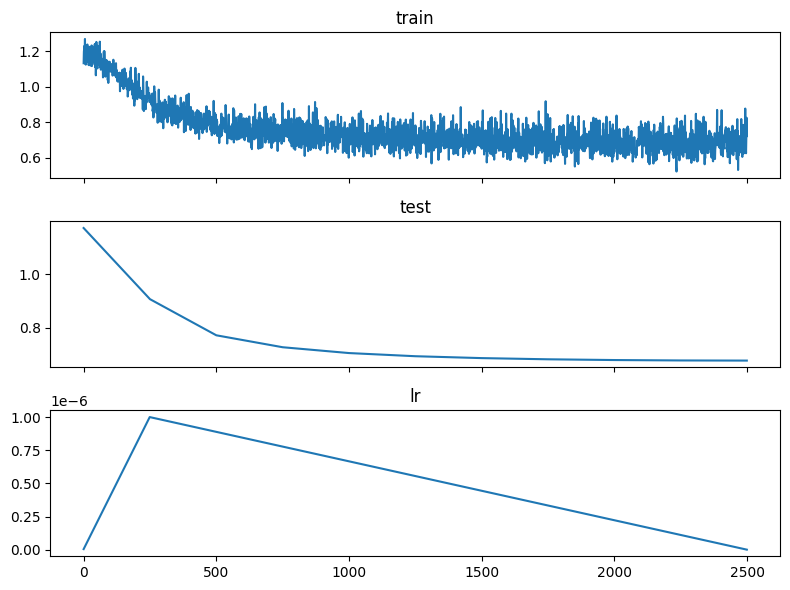

In [142]:
model = train_classifier(
    model,
    dataset_train,
    dataset_test,
    params['learning_rate'],
    params['epochs'],
    params['warmup_ratio'],
    params['eval_every'],
    print_train=False,
    plot=True,
)

In [143]:
def test_accuracy(model, dataset_test):
    predictions_list = [] # list to store every batch of predictions
    for batch in dataset_test['input_ids']:
        logits = model(batch) # derive the logits of one batch of inputs
        prediction = torch.argmax(logits, dim=-1) # prediction is the highest value logit for each item in sequence
        predictions_list.append(prediction)
    
    predictions = torch.stack(predictions_list).view(1000, 20) # convert list to tensor and flatten batch dimension
    labels = dataset_test['labels'].view(1000, 20) # flatten batch dimension of labels
    
    print(f"Test Accuracy: {100.0 * score(predictions, labels):.2f}%") # calculate score
    print_line()

In [144]:
test_accuracy(model, dataset_test)

Test Accuracy: 67.85%
--------------------------------------------------------------------------------
